In [76]:
!pip install kornia

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import numpy as np
import kornia as K

from skimage import io, transform
from tqdm.notebook import tqdm
from itertools import chain

### Сети

In [84]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Synthesizer(nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.fc = nn.Linear(n, 3 * m ** 2)
        self.sigmoid = nn.Sigmoid()
        self.reshape = Reshape(-1, 3, m, m)
        self.conv = nn.Conv2d(3, 3, 3)
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, x):
        x = x.float()
        x = self.sigmoid(self.fc(x))
        x = self.reshape(x)
        
        #x = self.upsample(x)
        
        # 16
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        #x = self.sigmoid(self.conv(x))
        
        return x.double()
    
    
class Recognizer(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.conv0 = nn.Conv2d(3, 96, 5, padding=2)
        self.conv = nn.Conv2d(96, 96, 5, padding=2)
        self.pool = nn.MaxPool2d(3, padding=(1, 0))
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(96)
        #self.fc = nn.Linear(192, n) # w/o background
        self.fc = nn.Linear(576, n) # with background
        
    def forward(self, x):
        x = x.float()
        
        #x = self.batchnorm(self.relu(self.pool(self.conv0(x))))
        x = self.relu(self.pool(self.conv0(x)))
        #x = self.batchnorm(self.relu(self.pool(self.conv(x))))
        x = self.relu(self.pool(self.conv(x)))
        #x = self.batchnorm(self.relu(self.pool(self.conv(x))))
        x = self.relu(self.pool(self.conv(x)))
        
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x.double()
    
    
class Renderer(nn.Module):
    def __init__(self, size):
        super(Renderer, self).__init__()        
        self.color_jitter = K.augmentation.ColorJitter(0.1, 0.1, 0.1, 0.1, p=0.5)
        self.size = size # size of marker (with background)
  
    def forward(self, x):
        '''
        # affine transformation
        affine_sigma = np.random.uniform(0.01, 0.1, 1)
        affine_matrix = torch.tensor([[1, 0, 0], [0, 1, 0]]) +\
            torch.normal(torch.zeros(2, 3), torch.full((2, 3), float(affine_sigma)))
        x = K.geometry.transform.affine(x.float(), affine_matrix)
        
        
        # noise
        for i in range(x.shape[0]):
            # same parameters for each channel
            g = float(np.random.uniform(0.001, 0.003, 1))
            Jahne_sigma = float(np.random.uniform(0.001, 0.3, 1))
            std = torch.sqrt(g * torch.mean(x[i], axis=[1, 2]) + Jahne_sigma ** 2)
            for j in range(x[i].shape[0]):
                x[i][j] = x[i][j] +\
                    torch.normal(torch.zeros(self.size, self.size), torch.full((self.size, self.size), float(std[j])))
        
        # color transformation
        x = self.color_jitter(x)
        '''
        # blurring
        blur_sigma = np.random.uniform(0.001, 0.5, 1)
        x = K.filters.gaussian_blur2d(x, (3, 3), (blur_sigma, blur_sigma))
        return x

###  Функции обучения и тестирования

In [85]:
def train(device, background_dataloader,
          synt_net, rend_net, rec_net, 
          criterion, optimizer, epochs, n, m):

    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        accuracy = torch.tensor([])
        
        #for i in (range(int(num_strings / batch_size))):
        for batch in background_dataloader:
            # generate batch with random bit strings
            input_bit_string_batch = torch.tensor(
                np.random.choice([-1, 1], size=(len(batch), n))
            ).to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            synt_outputs = synt_net(input_bit_string_batch)
            synt_outputs_with_background = batch.clone()
            synt_outputs_with_background[:, :, (m // 2):(m + m//2),\
                                         (m // 2):(m + m//2)] = synt_outputs
            rend_outputs = rend_net(synt_outputs_with_background)
            #rend_outputs = rend_net(synt_outputs)
            rec_outputs = rec_net(rend_outputs)
            
            #print('input: ', input_bit_string_batch[0])
            #print('rec: ', torch.sign(rec_outputs[0]))
            
            # criterion = sigmoid
            # the loss is distributed between −1 (perfect recognition) and 0
            loss = torch.mean(-torch.mean(
                criterion(
                    input_bit_string_batch * rec_outputs
                ), axis=1
            ))
            
            # calculate accuracy
            accuracy = torch.cat([
                accuracy, torch.sum(
                    input_bit_string_batch == torch.sign(rec_outputs)
                    , axis=1)
            ])
            
            #print('loss', loss)
            loss.backward()
            
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        print('Epoch: ', epoch + 1)
        print('Loss: ', running_loss)
        print('Mean accuracy: {}\n'.format(torch.mean(accuracy / n)))

    print('Finished Training')
    
    
    
def test(device, background_dataloader,
         synt_net, rend_net, rec_net, n, m):
    
    errors = torch.tensor([])
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch in background_dataloader:
        #for i in tqdm(range(int(num_strings / batch_size))):
            # generate batch with random bit strings
            input_bit_string_batch = torch.tensor(
                np.random.choice([-1, 1], size=(len(batch), n))
            ).to(device)
            
            # calculate outputs
            synt_outputs = synt_net(input_bit_string_batch)
            #superimposing
            synt_outputs_with_background = batch.clone()
            synt_outputs_with_background[:, :, (m // 2):(m + m//2),\
                                         (m // 2):(m + m//2)] = synt_outputs
            #rend_outputs = rend_net(synt_outputs)
            rend_outputs = rend_net(synt_outputs_with_background)
            rec_outputs = rec_net(rend_outputs)
                        
            # calculate accuracy
            errors = torch.cat([
                errors, torch.sum(
                    input_bit_string_batch == torch.sign(rec_outputs)
                    , axis=1)
            ])
            #print(errors)
            
    print('Mean accuracy: {}\n'.format(torch.mean(errors / n)))

### Параметры

In [86]:
n = 32
m = 32

background_size = m * 2
resize_source_back = background_size * 2

batch_size = 16
#num_strings = 1000
epochs = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Загрузка предобученной модели

In [87]:
synt_net = Synthesizer(n, m)
rend_net = Renderer(background_size)
rec_net = Recognizer(n)

synt_net.load_state_dict(torch.load('/content/drive/MyDrive/SkMLproject2022/trained_nets/synt_net.pth'))
rend_net.load_state_dict(torch.load('/content/drive/MyDrive/SkMLproject2022/trained_nets/rend_net.pth'))
rec_net.load_state_dict(torch.load('/content/drive/MyDrive/SkMLproject2022/trained_nets/rec_net.pth'))

<All keys matched successfully>

In [88]:
synt_net.to(device)
rend_net.to(device)
rec_net.to(device)

Recognizer(
  (conv0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=(1, 0), dilation=1, ceil_mode=False)
  (relu): ReLU()
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=576, out_features=32, bias=True)
)

In [89]:
synt_net.eval()
rend_net.eval()
rec_net.eval()

Recognizer(
  (conv0): Conv2d(3, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=(1, 0), dilation=1, ceil_mode=False)
  (relu): ReLU()
  (batchnorm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=576, out_features=32, bias=True)
)

### Загрузка фотографий и bitstring

In [179]:
input_bit_string_batch = torch.load('/content/drive/MyDrive/SkMLproject2022/photos/input_bit_string_batch.pt')

In [183]:
jpeg_photos = [
  io.imread(f'/content/drive/MyDrive/SkMLproject2022/photos/photo_jpg/{i}.jpeg') for i in range(32)
]

In [193]:
jpeg_photos_processed = [
  x[:, x.shape[1] // 2 - x.shape[0] // 2 : x.shape[1] // 2 + x.shape[0] // 2] for i, x in enumerate(jpeg_photos)
]
jpeg_photos_processed = [
  transform.resize(x, (64, 64, 3)) for x in tqdm(jpeg_photos_processed)
]


  0%|          | 0/32 [00:00<?, ?it/s]

In [265]:
jpeg_photos_processed[19] = jpeg_photos[19][jpeg_photos[19].shape[0] // 2 - jpeg_photos[19].shape[1]//2:jpeg_photos[19].shape[0] // 2 + jpeg_photos[19].shape[1] // 2, :]
jpeg_photos_processed[19] = transform.resize(jpeg_photos_processed[19], (64, 64, 3))

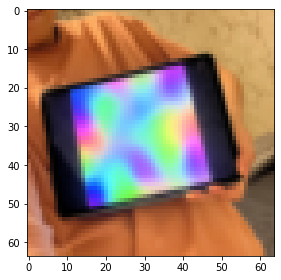

In [266]:
io.imshow(jpeg_photos_processed[19])

In [267]:
jpeg_photos_processed_tensor = torch.Tensor([x.transpose(2, 0, 1) for x in jpeg_photos_processed])

In [273]:
rec_outputs = torch.sign(rec_net(jpeg_photos_processed_tensor))

### Прогон фотографий через Recognizer

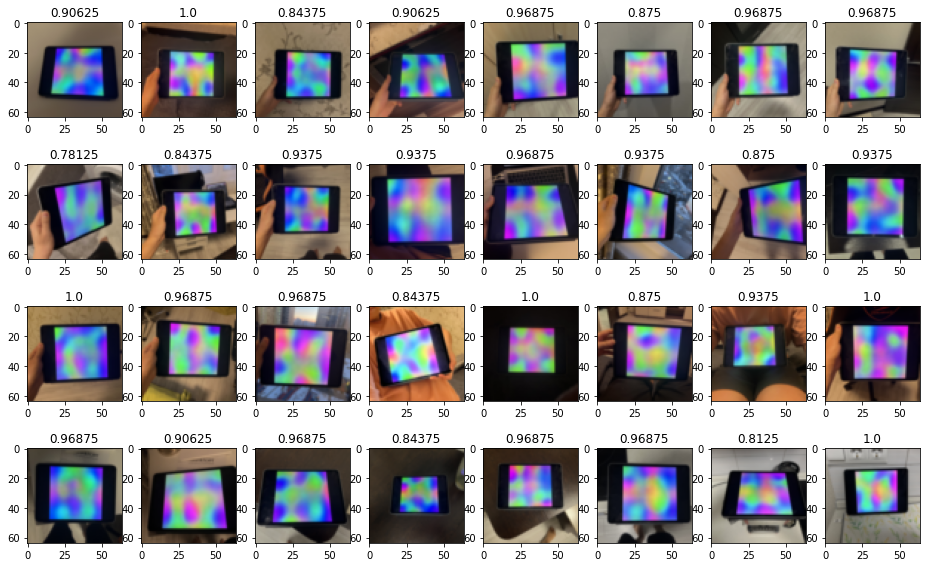

In [271]:
from matplotlib import pyplot as plt

def indexer_gen(nrows, ncols):
  row = 0
  col = 0
  i = 0
  while True:
    yield row, col
    i += 1
    row = i // ncols
    col = i % ncols

indexer = indexer_gen(4, 8)
fig, axes = plt.subplots(4, 8, figsize=(16, 10))


for i in range(32):
  index = next(indexer)
  axes[index].imshow(jpeg_photos_processed[i])
  axes[index].set_title(torch.mean(torch.sum(rec_outputs[i] == input_bit_string_batch[i]) / n).numpy())


### Средняя точность

In [277]:
(rec_outputs == input_bit_string_batch).float().mean()

tensor(0.9277)